# Предсказание синтезируемости молекул лекарств с помощью глубокого обучения

![](./img/given_mols.png)

Для выполнения тестового задания, я написал небольшую обертку над классом ```VAEUtils``` из пакета ```chemical_vae```. В нем имплементированы методы ```decode_to_smiles```, ```predict```, ```decompose_2d```, ```draw```, ```plot_decomposed```.

* В первые два я включил пайплайн, который обрабатывает SMILES-строку, чтобы она была пригодна для дальнейшего использования родительским классом
* Метод ```decompose_2d``` понижает размерность скрытого слоя (слоя VAE, из которого происходит декодировка новой молекулы), что позволяет отобразить скрытый слой на плоскость
* Методы ```draw```, ```plot_decomposed``` используются для отрисовки получившихся молекул и декомпозиции соответственно

Сверху приведено изображение молекул из задания

## Chemical VAE

Модель вариационного автоэнкодера, предложенная в [репозитории](https://github.com/aspuru-guzik-group/chemical_vae), имеет несколько ключевых отличий от классической VAE.
* Во-первых, на этапе декодирования молекулы из латентного пространства, последний слой декодера определяет распределение вероятностей по всем возможным символам для каждой позиции SMILES-строки (*probability distribution over all possible characters at each position*). Таким образом, у каждого атома существует вероятность появиться или не появиться в записи молекулы. Это делает процесс декодирования молекулы стохастическим, что в свою очередь, помогает генерировать больше различных молекул.


* Во-вторых, помимо энкодера и декодера в модели присутствует полносвязная сеть с 1000 нейронов для предсказания свойств молекул. Выходные данные этой сети используются в целях оптимизации автокодировщика, чтобы генерировать молекулы, которые имеют лекарственные свойства и их легко синтезировать (*the most drug-like molecule that is also easy to synthesize*). Процесс обучения сети изображен рисунке (b)

![рис. 1](./img/ris_1.jpg)

In [1]:
import chemvae_wrapper
import pandas as pd
import numpy as np

from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'

import matplotlib.pyplot as plt
%matplotlib inline

Install CUDA and cudamat (for python) to enable GPU speedups.


RDKit WARNING: [14:25:48] Enabling RDKit 2019.09.3 jupyter extensions
Using TensorFlow backend.


In [2]:
mols = ['Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1',
        'CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C',
        'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1']

In [3]:
model = chemvae_wrapper.WrappedVAE(directory='/Users/suess_mann/wd/jb_test/bio/chemical_vae/models/zinc_properties')

/Users/suess_mann/opt/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!



## Encoding & Decoding

Благодаря написанное обертке, закодирование и декодирование молекулы происходит с помощью единственного метода. Значения ```noise``` и ```decode_attempts``` были выбраны опытным путем с использованием знания о том, что средняя дистанция между молекулами в тренировочных данных равняется 19.66

In [4]:
decoded = model.decode_to_smiles(smiles=mols, decode_attempts=250, noise=5)
decoded.head(10)

,smiles,distance,count,frequency,mol,parent
0,Cc1ccc(S[N+]2=NC(=O)Nc3ccccc32)cc1,10.630586,1,0.027778,<rdkit.Chem.rdchem.Mol object at 0x136db9760>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
1,Cc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1,10.719078,10,0.277778,<rdkit.Chem.rdchem.Mol object at 0x12ad3c030>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
2,Cc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1,10.719078,17,0.472222,<rdkit.Chem.rdchem.Mol object at 0x1334f50d0>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
3,Fc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1,14.071545,2,0.055556,<rdkit.Chem.rdchem.Mol object at 0x12ad32d00>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
4,C1cccc(C[n+]2=NC(=O)Nc3ccccc32)cc1,16.266774,1,0.027778,<rdkit.Chem.rdchem.Mol object at 0x1334f5030>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
5,C1cccc(C[N+]2=NC(=O)Nc3ccccc32)cc1,16.266774,5,0.138889,<rdkit.Chem.rdchem.Mol object at 0x1334f5f80>,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
6,CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C,0.000000,2,0.222222,<rdkit.Chem.rdchem.Mol object at 0x136db9cb0>,CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
7,CN(C1cccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C,18.263268,7,0.777778,<rdkit.Chem.rdchem.Mol object at 0x136db9530>,CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
8,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1,0.000001,108,0.710526,<rdkit.Chem.rdchem.Mol object at 0x136de40d0>,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
9,COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)NN)cn2)CC1,2.773162,2,0.013158,<rdkit.Chem.rdchem.Mol object at 0x136de4ad0>,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1


In [5]:
decoded.groupby('parent', as_index=False)['smiles'].agg('count')

,parent,smiles
0,CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C,2
1,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1,9
2,Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1,6


В итоге мы декодировали молекулы:
* 2 для ```CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C	```
* 9 для ```COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1```
* 6 для ```Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1```

В некоторых случаях мы получили исходную закодированную молекулу.


## Property prediction

Предсказываем следующие свойства:
* ```qed``` – Qualitative Estimate of Drug-likeness (насколько молекула подобна лекарству)
* ```SAS``` – Synthetic Accessibility Score (сложность субстанции в производстве)
* ```logP``` – логарифм от коэффициента разделения

Я добавил еще одно свойство ```estimate```, которое используют авторы статьи для определения молекул, которые легко синтезируются и имеют лучшие лекарственные свойства (*a rough estimate of finding the most drug-like molecule that is also easy
to synthesize*). 

Вычисляется по формуле: $5 \times QED - SAS$

In [6]:
predicted_0 = model.predict(smiles=decoded)
predicted_0['best'] = 5 * predicted_0['qed'] - predicted_0['SAS']

In [7]:
top_5_predicted = predicted_0.sort_values('best', ascending=False).head()
top_5_predicted

,smiles,qed,SAS,logP,best
6,CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C,0.811588,2.219855,2.438276,1.838087
14,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)CC1,0.782345,2.282626,0.724625,1.629098
16,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)nn2)CC1,0.758976,2.399571,0.220992,1.395309
9,COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)NN)cn2)CC1,0.754564,2.443028,0.039836,1.329793
8,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1,0.753152,2.478498,0.050346,1.287264


Изобразим топ-5 самых "лучших" молекул

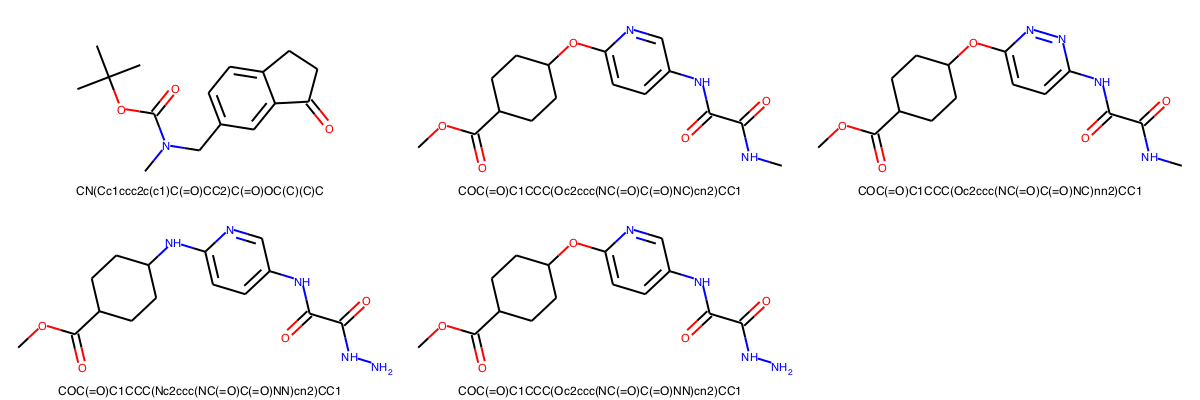

In [8]:
model.draw(top_5_predicted)

Но ведь интереснее пройти немного глубже и поискать новые молекулы от декодированных молекул

## Going deeper

Это займет некоторое время

In [9]:
depth = 3
smiles = mols
for i in range(depth):
    decoded_deep = model.decode_to_smiles(smiles, decode_attempts=100, noise=5)
    smiles = decoded_deep.smiles.values
    print(f'done with depth {i+1}')

done with depth 1
done with depth 2
done with depth 3


In [10]:
decoded_deep.shape

(455, 6)

Итого мы декодировали 532 молекулы. Посмотрим на их свойства

In [11]:
predicted_2 = model.predict(decoded_deep)
predicted_2['best'] = 5 * predicted_2['qed'] - predicted_2['SAS']

In [12]:
top_5_predicted = predicted_2.sort_values('best', ascending=False).head()
top_5_predicted

,smiles,qed,SAS,logP,best
418,COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)OC)cn2)CC1,0.800254,2.255672,1.138825,1.745597
4,OC1(NC(=O)-c2ccc(Cl)cc2)c2ccccc2N1,0.789076,2.230331,2.408142,1.715051
3,OC1(NC(=O)Oc2ccc(Cl)cc2)c2ccccc2N1,0.796993,2.289480,2.339394,1.695486
451,COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)OC)cn2)CC1,0.791610,2.264586,0.886928,1.693464
6,O=C1OCC(N)(Cc2ccc(F)cc2)c2ccccc2N1,0.768328,2.155262,2.480406,1.686376


Результаты получились намного интереснее и разнообразнее. Теперь в топ-5 нет молекул, которые повторяют по молекулярному строению исходные.

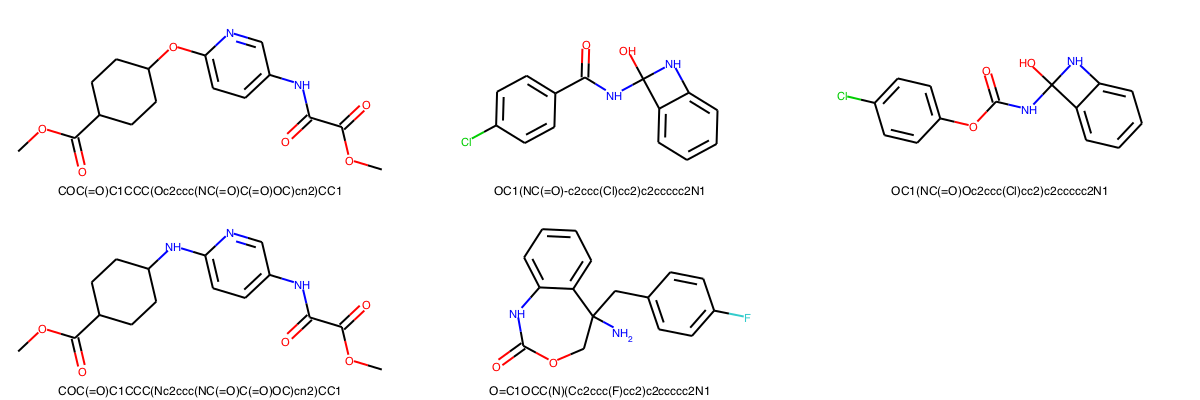

In [13]:
model.draw(top_5_predicted)

## Decomposition

Я решил так же понизить размерность эмбеддингов каждой из молекул, чтобы отобразить их на плоскости. Цветовая дифференциация основана на значении свойства ```best```.

In [14]:
y = model.decompose_2d(smiles=predicted_2)

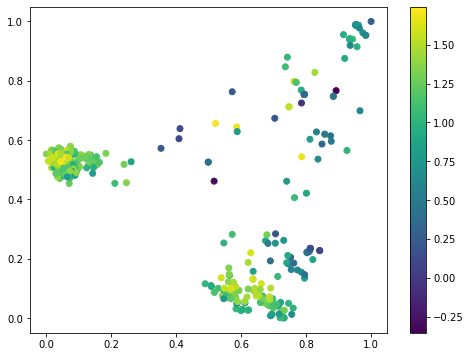

In [15]:
plt.figure(figsize=(8, 6))
model.plot_decomposed(y, predicted_2['best'])